In [16]:
import torch

# Device configuration
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
# device = torch.device("cpu")

In [17]:
# Import MNIST Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

print(train_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


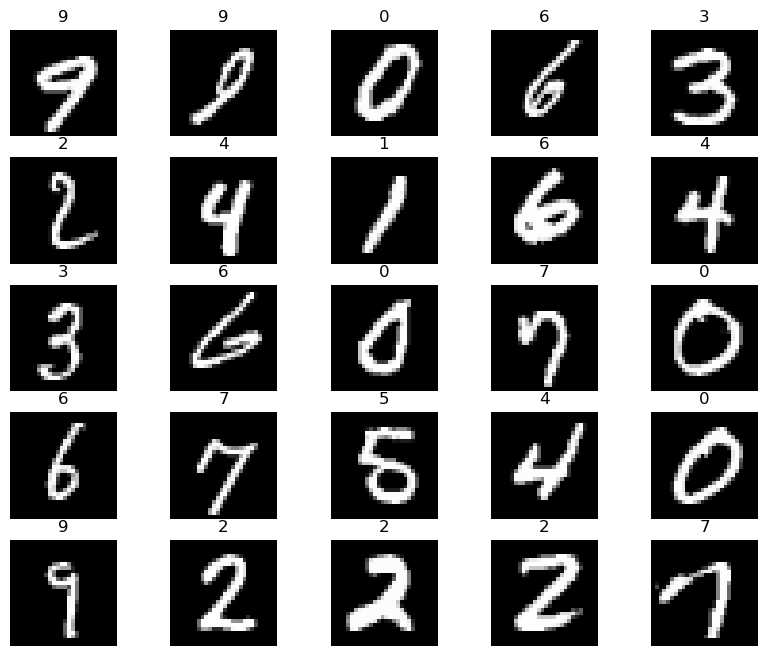

torch.Size([1, 28, 28])


In [18]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()
print(img.size())

In [19]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x14f32f530>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x14dc11280>}

In [20]:
import torch.nn as nn
f1 = 3
p1 = 0

f2 = 5
p2 = 0

def get_size(n, f, p=0, s=1, pool=1):
    return int(((n + 2*p - f)/s + 1)/pool)


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=f1,              
                stride=1,                   
                padding=p1,                  
            ),
            nn.BatchNorm2d(16),
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2, stride=2),    
        )
        self.conv1_size = get_size(28, f1, p1, s=1, pool=2)
        self.conv2 = nn.Sequential(         
            nn.Conv2d(
                in_channels=16,              
                out_channels=32,            
                kernel_size=f2,              
                stride=1,                   
                padding=p2,                  
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2, stride=2),               
        )
        self.conv2_size = get_size(self.conv1_size, f2, p2, s=1, pool=2)
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * self.conv2_size * self.conv2_size, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

# del cnn
cnn = CNN()
print(cnn)
print(cnn.conv1_size)
print(cnn.conv2_size)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=512, out_features=10, bias=True)
)
13
4


In [21]:
loss_func = nn.CrossEntropyLoss()   
loss_func


CrossEntropyLoss()

In [22]:
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.005)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.005
    maximize: False
    weight_decay: 0
)

In [23]:
import torch
from torch.autograd import Variable

num_epochs = 1

def train(num_epochs, cnn, loaders):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
    
    for epoch in range(num_epochs):
        correct = 0
        total = 0
        
        for i, (images, labels) in enumerate(loaders['train']):
            
            # Gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # Clear gradients for this training step   
            optimizer.zero_grad()           
            
            # Backpropagation, compute gradients 
            loss.backward()    
            
            # Apply gradients             
            optimizer.step()
            
            # Calculate training accuracy
            _, predicted = torch.max(output.data, 1)
            total += b_y.size(0)
            correct += (predicted == b_y).sum().item()

            if (i == 0) and (epoch == 0):
                print("First loss:", loss.item(), "accuracy: ", 100 * correct / total)
            
            if (i + 1) % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                print('Epoch [{}/{}], Training Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, 100 * correct / total))
        
        # Calculate and print the accuracy for this epoch
        train_accuracy = 100 * correct / total
        print('Epoch [{}/{}], Training Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, train_accuracy))

# Assuming `cnn`, `loaders`, `loss_func`, and `optimizer` are already defined
train(num_epochs, cnn, loaders)


First loss: 2.5094001293182373 accuracy:  5.0
Epoch [1/1], Step [100/600], Loss: 0.2576
Epoch [1/1], Training Accuracy: 91.05%
Epoch [1/1], Step [200/600], Loss: 0.0536
Epoch [1/1], Training Accuracy: 94.07%
Epoch [1/1], Step [300/600], Loss: 0.0060
Epoch [1/1], Training Accuracy: 95.20%
Epoch [1/1], Step [400/600], Loss: 0.0648
Epoch [1/1], Training Accuracy: 95.89%
Epoch [1/1], Step [500/600], Loss: 0.1678
Epoch [1/1], Training Accuracy: 96.28%
Epoch [1/1], Step [600/600], Loss: 0.0156
Epoch [1/1], Training Accuracy: 96.64%
Epoch [1/1], Training Accuracy: 96.64%


In [24]:
def test():
    # Set the model to evaluation mode
    cnn.eval()
    # Disable gradient calculation
    with torch.no_grad():
        correct = 0
        total = 0
        class_correct = {i: 0 for i in range(10)}  # Assuming 10 classes (0-9)
        class_total = {i: 0 for i in range(10)}
        class_confidences = {i: [] for i in range(10)}  # Assuming 10 classes (0-9)

        for images, labels in loaders['test']:
            # Forward pass
            test_output, last_layer = cnn(images)
            # Get probabilities from softmax
            probs = torch.softmax(test_output, dim=1)
            # Get predictions and their confidence
            confidence, pred_y = torch.max(probs, 1)
            # Update the correct predictions count
            correct += (pred_y == labels).sum().item()
            # Update the total samples count
            total += labels.size(0)
            
            # Store confidences and corresponding samples, predictions, and labels for each class
            for i in range(len(images)):
                label = labels[i].item()
                pred = pred_y[i].item()
                class_correct[label] += (pred == label)
                class_total[label] += 1
                class_confidences[labels[i].item()].append((confidence[i].item(), images[i], labels[i], pred_y[i]))

        # Calculate the overall accuracy
        accuracy = correct / total
        # Print the overall accuracy
        print('Test Accuracy of the model on the 10000 test images: %.2f%%' % (accuracy * 100))

        # Print accuracy per class
        for class_id in range(10):
            if class_total[class_id] > 0:
                class_accuracy = class_correct[class_id] / class_total[class_id]
                print(f'Accuracy for class {class_id}: {class_accuracy * 100:.2f}%')
            else:
                print(f'Accuracy for class {class_id}: No samples')

        return class_confidences

class_confidences = test()

Test Accuracy of the model on the 10000 test images: 98.75%
Accuracy for class 0: 98.98%
Accuracy for class 1: 99.56%
Accuracy for class 2: 99.13%
Accuracy for class 3: 98.91%
Accuracy for class 4: 98.88%
Accuracy for class 5: 98.88%
Accuracy for class 6: 99.16%
Accuracy for class 7: 98.54%
Accuracy for class 8: 97.13%
Accuracy for class 9: 98.22%


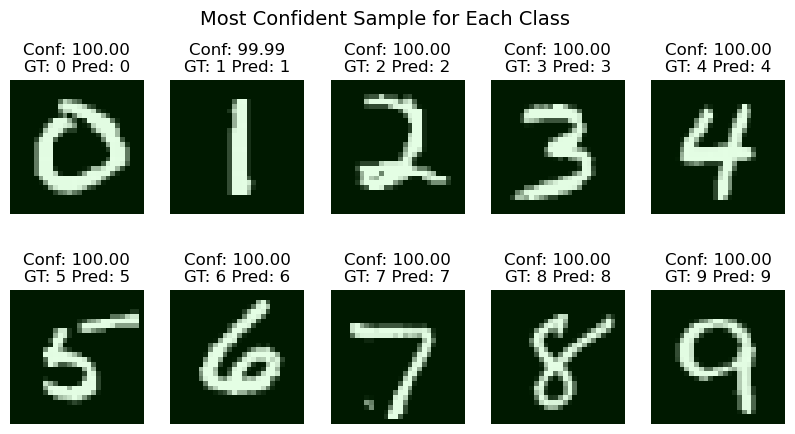

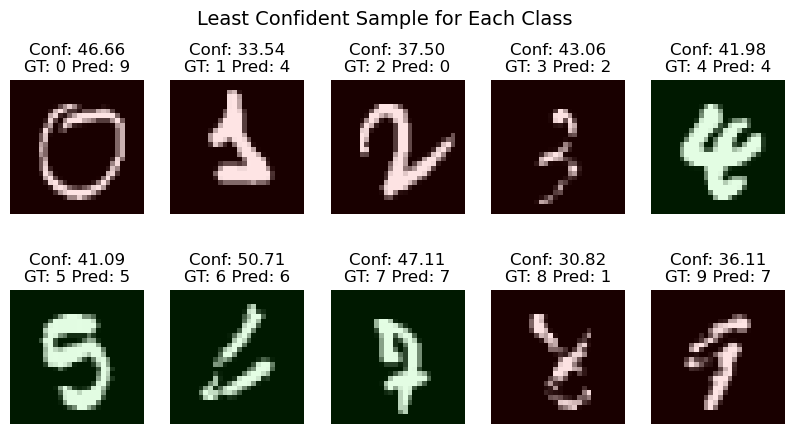

In [25]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Sort and select most and least confident samples for each class
most_confident_samples = []
least_confident_samples = []

for class_id, samples in class_confidences.items():
    samples.sort(key=lambda x: x[0], reverse=True)
    if samples:
        most_confident_samples.append(samples[0])
        least_confident_samples.append(samples[-1])


# Tinting function
def tint_image(image, label, pred):
    image = image.permute(1, 2, 0).cpu().numpy()
    if label == pred:
        tint = [0, 1, 0]  # Green tint for correct predictions
    else:
        tint = [1, 0, 0]  # Red tint for incorrect predictions
    
    tinted_image = image * 0.9 + np.array(tint) * 0.1
    return tinted_image

# Visualize the samples in a grid
def visualize_samples(samples, title):
    fig, axs = plt.subplots(2, 5, figsize=(10, 5))
    fig.suptitle(title, fontsize=14)
    for i, (confidence, image, label, pred) in enumerate(samples):
        ax = axs[i // 5, i % 5]
        # ax.imshow(image.permute(1, 2, 0).cpu().numpy(), cmap='grey')
        tinted_image = tint_image(image, label, pred)
        ax.imshow(tinted_image)
        ax.set_title('Conf: %.2f\nGT: %d Pred: %d' % (confidence * 100, label.item(), pred.item()))
        ax.axis('off')
    plt.show()

# Visualize the most confident and least confident samples for each class
visualize_samples(most_confident_samples, 'Most Confident Sample for Each Class')
visualize_samples(least_confident_samples, 'Least Confident Sample for Each Class')


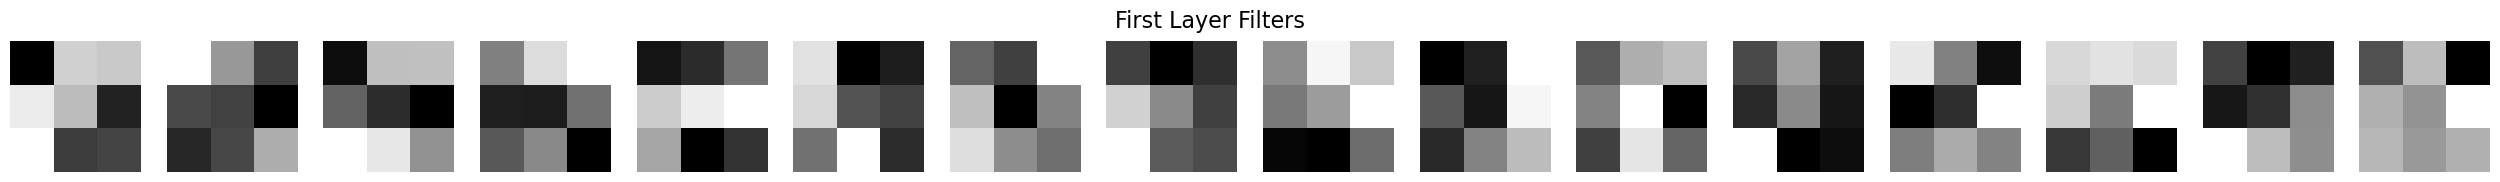

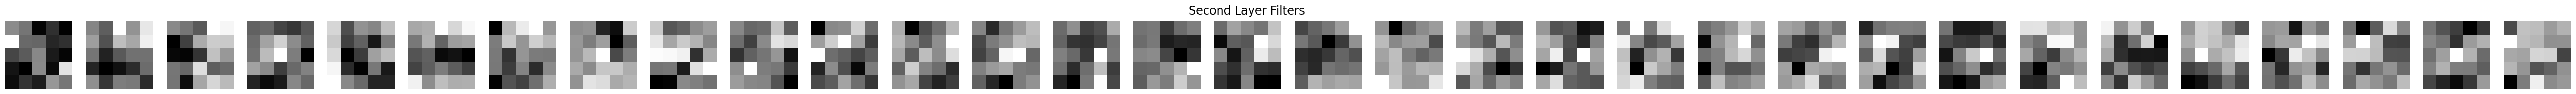

In [26]:

import numpy as np

def visualize_filters(layer, title):
    filters = layer[0].weight.data.cpu().numpy()
    num_filters = filters.shape[0]
    fig, axs = plt.subplots(1, num_filters, figsize=(num_filters * 2, 2))
    fig.suptitle(title, fontsize=16)
    for i in range(num_filters):
        ax = axs[i]
        ax.imshow(filters[i, 0, :, :], cmap='gray')  # Assuming single channel filters
        ax.axis('off')
    plt.show()

# Assuming your first conv layer is named conv1
visualize_filters(cnn.conv1, 'First Layer Filters')
visualize_filters(cnn.conv2, 'Second Layer Filters')

